# Keras Subclassing API

## Classify images with a toy ResNet

In this notebook, we will train a reduced version of the popular ResNet neural network, which uses residual connections, to classify images from the CIFAR10 dataset. The main difference between this notebook and the previous one is the use of the Subclassing API instead of the Functional one.

##### Import the required modules

In [3]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt

##### Download the CIFAR10 Dataset

As in the previous notebook, will use the `keras.datasets` package to download the dataset. We will also do some (manual) normalization of the data. Notice that it's actually better to use a `Normalization()` Keras layer, so that the input pipeline remains part of your model (more portable). But this will do for a simple example.

The `to_categorical` method applies one-hot encoding to the integer class labels. 

In [4]:
(x_train, y_train_int), (x_test, y_test_int) = keras.datasets.cifar10.load_data()

x_train = x_train.astype("float32") / 255.0
x_test = x_test.astype("float32") / 255.0
y_train = keras.utils.to_categorical(y_train_int, 10)
y_test = keras.utils.to_categorical(y_test_int, 10)

170498071/170498071 [==============================] - 2s 0us/step



CIFAR10 contains 32x32 color images, so the shape of `x_train` and `x_test` is $(n_{images}, 32, 32, 3)$, whereas the shape of `y_train` and `y_test` is $(n_{images}, 10)$ because of the one-hot encoding.

In [5]:
print(x_train.shape)
print(y_train.shape)

(50000, 32, 32, 3)
(50000, 10)


Let us define the class names (they are not defined in the dataset)

In [6]:
class_names = [
    'airplane',
    'automobile',
    'bird',
    'cat',
    'deer',
    'dog',
    'frog',
    'horse',
    'ship',
    'truck',
]

Finally, let us plot some images as an example. Wow, the resolution is quite low...!

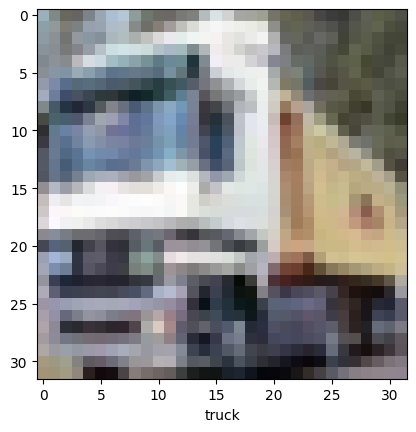

In [7]:
idx = 1
plt.figure()
plt.imshow(x_train[idx])
plt.xlabel(class_names[y_train_int[idx][0]])
plt.grid(False)
plt.show()

##### Let us build a small ResNet-like CNN model with the Subclassing API

ResNet-like networks are constructed as a stack of blocks each with the same structure.

![resnet-architecture-diagram-deep-learning-eningeer-italia-skip-connection-guida-italiano-blog-machine-learning-deep-learning-1024x290.png](attachment:resnet-architecture-diagram-deep-learning-eningeer-italia-skip-connection-guida-italiano-blog-machine-learning-deep-learning-1024x290.png)

So, let us first define one of these blocks as a custom `keras.layers.Layer`. Ours will be simpler than the original ResNet one (no 1x1 convolutions, batch normalization, etc).

Notice that in the slides, we defined a custom layer that used core TF ops internally. Here, we show that a custom layer can also contain other high-level Keras layers.

In [8]:
class ResNetBlock(keras.layers.Layer):
    def __init__(self, filters):
        super(ResNetBlock, self).__init__()
        filters1, filters2 = filters
        # first 3x3 conv
        self.conv2a = keras.layers.Conv2D(filters1, 3, activation='relu', padding='same')
        # second 3x3 conv
        self.conv2b = keras.layers.Conv2D(filters2, 3, activation='relu', padding='same')

    # we don't need a build function since conv layers weights tensors shapes don't depend on the input shape   
    def call(self, inputs):
        x = self.conv2a(inputs)
        x = self.conv2b(x)
        # residual connection implemented here
        x += inputs
        return x

Let us now define the entire toy ResNet model as a custom `keras.Model` which uses the `ResNetBlock` internally. We will use the same architecture as in the previous notebook. Note that at this point, we could also have used either the Sequential or the Functional APIs to build the model.

In [9]:
class ResNet(keras.Model):

    def __init__(self):
        super(ResNet, self).__init__()
        self.conv_1    = keras.layers.Conv2D(32, 3, activation="relu")
        self.conv_2    = keras.layers.Conv2D(64, 3, activation="relu")
        self.maxpool   = keras.layers.MaxPooling2D(3)
        self.block_1   = ResNetBlock((64, 64))
        self.block_2   = ResNetBlock((64, 64))
        self.conv_3    = keras.layers.Conv2D(64, 3, activation='relu')
        self.glopool   = keras.layers.GlobalAveragePooling2D()
        self.dense_1   = keras.layers.Dense(256, activation="relu")
        self.do        = keras.layers.Dropout(0.5)
        self.dense_2   = keras.layers.Dense(10)

    def call(self, inputs):
        x = self.conv_1(inputs)
        x = self.conv_2(x)
        x = self.maxpool(x)
        x = self.block_1(x)
        x = self.block_2(x)
        x = self.conv_3(x)
        x = self.glopool(x)
        x = self.dense_1(x)
        x = self.do(x)
        x = self.dense_2(x)
        return x

Let us create an instance of the model. In general we cannot show summary or plot the model with this API.

In [10]:
model = ResNet()

2022-11-01 09:40:57.725370: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-11-01 09:40:57.725408: W tensorflow/stream_executor/cuda/cuda_driver.cc:263] failed call to cuInit: UNKNOWN ERROR (303)
2022-11-01 09:40:57.725427: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (p-7817b2ad-42a3-441f-8072-b020be286d3c): /proc/driver/nvidia/version does not exist
2022-11-01 09:40:57.725757: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


##### Compile the model

Let us now compile the model, specifying optimizer, loss function and metrics.

Notice that, differently from the previous notebook, we use `RMSprop` instead of `Adam` this time. We also use the `CategoricalCrossentropy` loss (not the "sparse" variant) since we have generated 1-hot labels, and we use the `from_logits` option because the last layer of the model does not include a softmax activation. Using `from_logits` is normally more stable from a numerical point of view, so it's suggegested.


In [11]:
model.compile(
    optimizer=keras.optimizers.RMSprop(1e-3),
    loss=keras.losses.CategoricalCrossentropy(from_logits=True),
    metrics=["accuracy"],
)

##### Train the model

Notice the new option `validation_split=0.2`. More details on this later.

In [12]:
model.fit(x_train, y_train, batch_size=64, epochs=10, validation_split=0.2)

Epoch 1/10
625/625 [==============================] - 133s 211ms/step - loss: 1.8952 - accuracy: 0.2871 - val_loss: 1.5797 - val_accuracy: 0.4177
Epoch 2/10
625/625 [==============================] - 132s 211ms/step - loss: 1.4714 - accuracy: 0.4598 - val_loss: 1.6104 - val_accuracy: 0.4283
Epoch 3/10
625/625 [==============================] - 132s 211ms/step - loss: 1.2465 - accuracy: 0.5531 - val_loss: 1.1280 - val_accuracy: 0.6013
Epoch 4/10
625/625 [==============================] - 132s 211ms/step - loss: 1.0766 - accuracy: 0.6164 - val_loss: 0.9854 - val_accuracy: 0.6436
Epoch 5/10
625/625 [==============================] - 132s 212ms/step - loss: 0.9539 - accuracy: 0.6626 - val_loss: 0.9436 - val_accuracy: 0.6684
Epoch 6/10
625/625 [==============================] - 132s 211ms/step - loss: 0.8625 - accuracy: 0.6978 - val_loss: 0.7869 - val_accuracy: 0.7270
Epoch 7/10
625/625 [==============================] - 132s 212ms/step - loss: 0.7844 - accuracy: 0.7267 - val_loss: 0.7541 -

##### Evaluate on unseen data

Let us test the model on unseen data using the `evaluate()` method. The model is slightly over-fitting the training data.

In [13]:
test_loss, test_acc = model.evaluate(x_test,  y_test, verbose=2)
print('\nTest accuracy:', test_acc)

313/313 - 8s - loss: 0.7076 - accuracy: 0.7726 - 8s/epoch - 26ms/step

Test accuracy: 0.772599995136261


##### Perform a prediction on a single image

Let us run a prediction on one image and see the result. Notice that some bars in the bar chart are negative this time because we have logits, not probabilities.

1/1 [==============================] - 0s 145ms/step
Predicted label: 6 (frog)
Real label: 6 (frog)


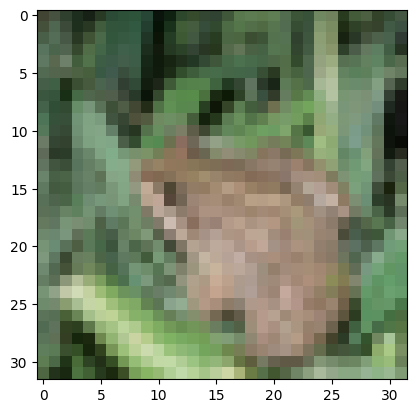

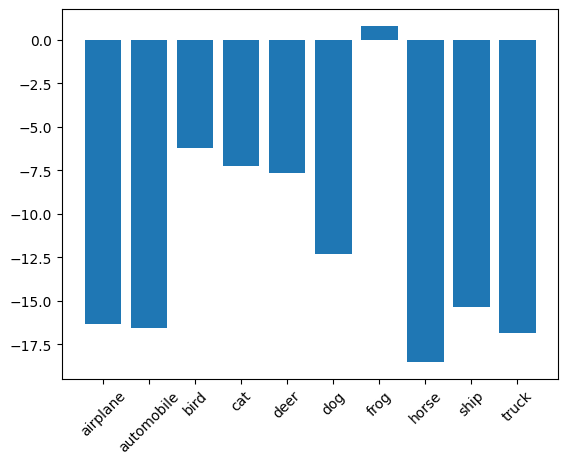

In [14]:
idx = 4

pred = model.predict(x_test[idx].reshape(1, 32, 32, 3))
pred_lidx = tf.argmax(pred[0])
pred_label = class_names[pred_lidx]

print("Predicted label: {} ({})".format(pred_lidx, pred_label))
print("Real label: {} ({})".format(y_test_int[idx][0], class_names[y_test_int[idx][0]]))

plt.figure()
plt.imshow(x_test[idx])
plt.grid(False)
plt.figure()
plt.bar(range(len(class_names)), pred[0], tick_label=class_names)
plt.xticks(rotation=45)
plt.show()

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=7817b2ad-42a3-441f-8072-b020be286d3c' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>